In [41]:
import treetime
import matplotlib.pyplot as plt
from Bio import Phylo
import os
import numpy as np
import pandas as pd
import random

pd.set_option("display.max_rows", None, "display.max_columns", None)
random.seed(1152342, 2)

tree_path = "../../docs/results/latest/branch_support/branch_support.nwk"
metadata_path = "../../docs/results/latest/metadata/metadata.tsv"
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"
outdir = "../../docs/results/latest/timetree/"

plt.rc('lines', linewidth=1)
dpi = 400

NO_DATA_CHAR = "NA"
DATE_COL = "Date"
NAME_COL = "Sample"
REF_DATE = 1992.0
REF_LEN = 4653728
CONFIDENCE=0.95
N_IQD=3


Attempting to parse dates...
	Using column 'Sample' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.

0.00	-TreeAnc: set-up

0.56	-SequenceData: loaded alignment.
0.56	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

0.56	-SeqData: making compressed alignment...

2.04	-SequenceData: constructed compressed alignment...
2.21	--ClockTree: Setting precision to level 2

2.24	-ClockTree._assign_dates: assigned date contraints to 523 out of 523 tips.
2.35	--ClockTree.date2dist: Setting new molecular clock. rate=9.668e-09,
    	  R^2=0.2481


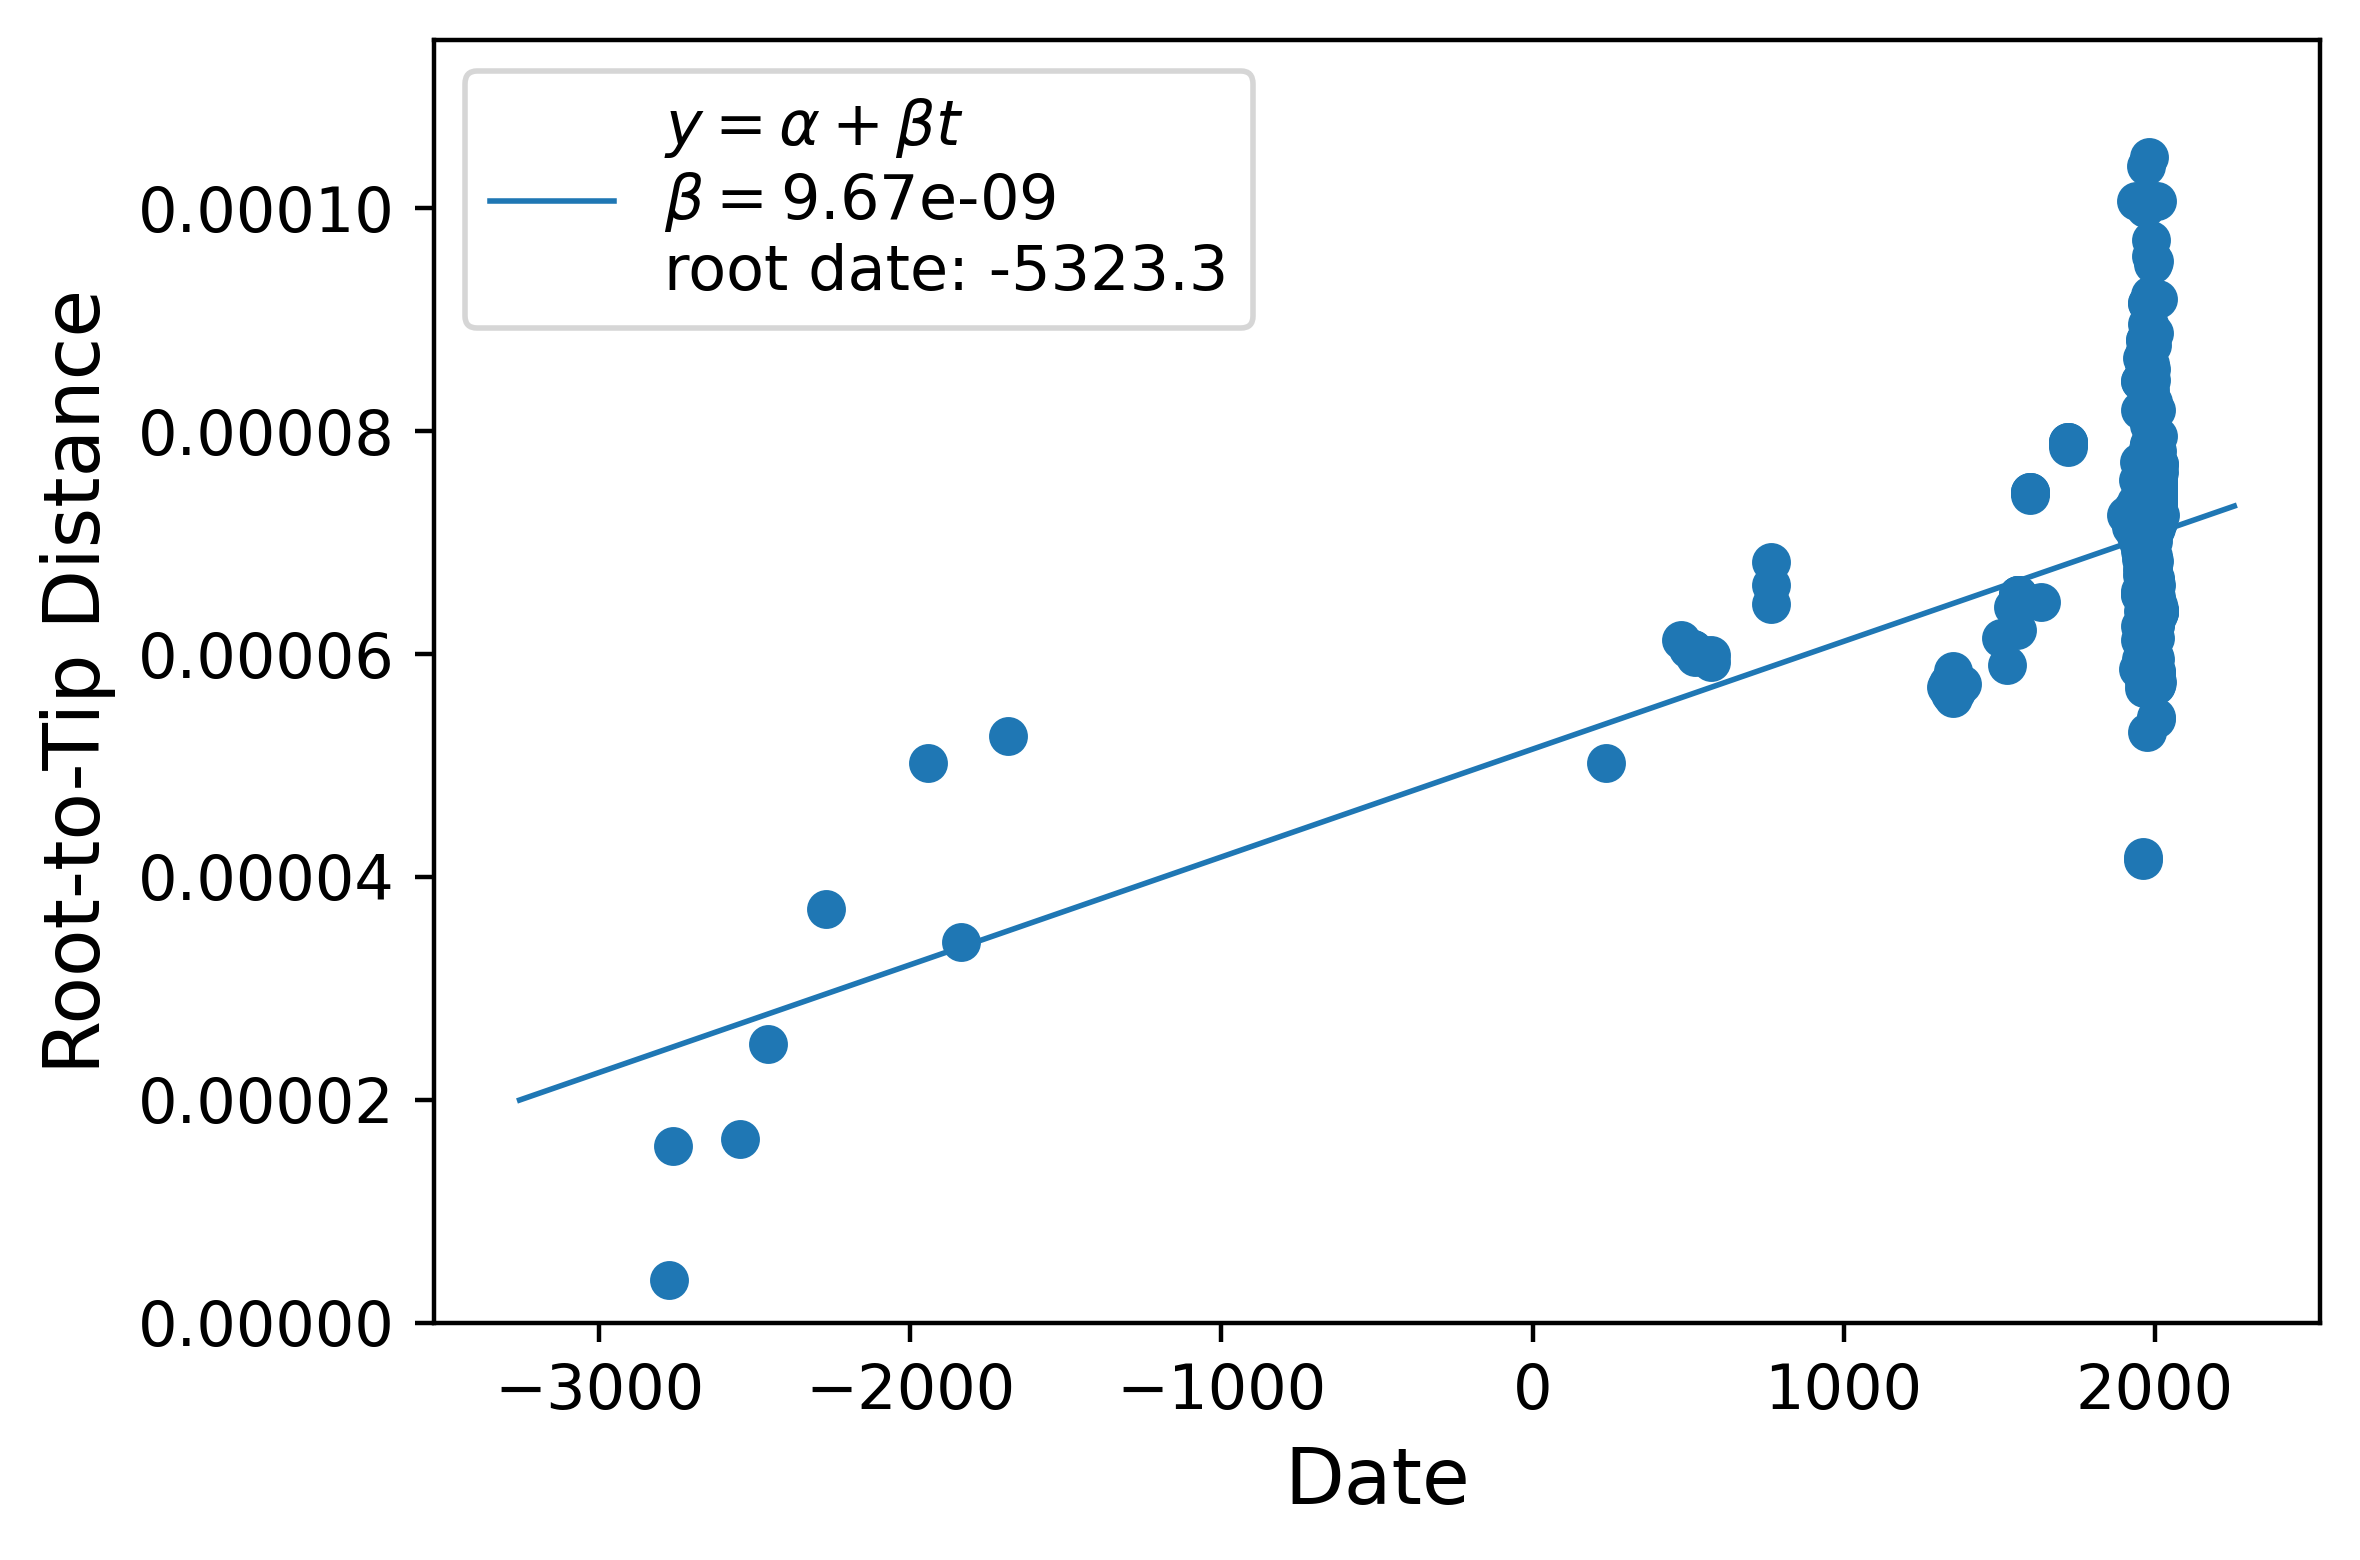

In [18]:
# Create a basic TimeTree Object
dates = treetime.utils.parse_dates(metadata_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)
dates["Reference"] = REF_DATE

tt = treetime.TreeTime(dates=dates, 
                       aln=aln_path,
                       tree=tree_path, 
                       seq_len=REF_LEN,
                       verbose=4, 
                       fill_overhangs=False,)

# Remove outliers
tt.clock_filter(reroot=None, 
                n_iqd=N_IQD, 
                plot=False,
               )

# Root to tip regression
fig, (ax1) = plt.subplots(1, dpi=400)
tt.plot_root_to_tip(
    ax=ax1,
    )
#ax1.get_lines()[0].set_color("#1f77b4")
#ax1.get_lines()[0].set_color("#ff7f0e")
ax1.set_xlabel("Date")
ax1.set_ylabel("Root-to-Tip Distance")

out_path = os.path.join(outdir, "timetree_rtt_pre.jpg") 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

In [23]:
# Run time tree analysis
# Do I need the local modification of setting the root branch length to 0?

# PARAM SET 1
#tt.run()

# PARAM SET 2
# Resolve polytomies might be problematic, nodes are being deleted and recreated.
# This may affect my node dataframe
tt.run(root=None, infer_gtr=True, relaxed_clock=False, max_iter=1,
                    branch_length_mode='input', n_iqd=3, resolve_polytomies=False,
                    Tc='skyline', time_marginal="assign", vary_rate=True)

# PARAM SET 3
# Remove time_marginal?


54.24	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint

54.24	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
     	tips at positions with AMBIGUOUS bases. This resulted in unexpected
     	behavior is some cases and is no longer done by default. If you want to
     	replace those ambiguous sites with their most likely state, rerun with
     	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.
54.24	--TreeAnc._ml_anc_joint: type of reconstruction: Joint
54.24	---TreeAnc._ml_anc_joint: Walking up the tree, computing likelihoods...
57.69	---TreeAnc._ml_anc_joint: Walking down the tree, computing maximum
     	   likelihood sequences...
57.80	---TreeAnc._ml_anc_joint: ...done
57.81	--TreeAnc.infer_gtr: counting mutations...
58.87	---TreeAnc.infer_gtr: counting mutations...done

58.88	-GTR: with alphabet: ['A', 'C', 'G', 'T', '-']
58.88	--GTR: ambiguous character: N
58.88	---GTR: init with dummy values!

58.88	-GTR: model inference
5

'success'

### Add dates to dataframe

In [46]:
tree_df = pd.read_csv(metadata_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index(NAME_COL, inplace=True)

# Create a new column for date
tree_df[DATE_COL + "_timetree"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df[DATE_COL + "_timetree_conf"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
for c in tt.tree.find_clades():
    #print(dir(c))
    #print(c.name, c.date, c.numdate)
    conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
    tree_df.at[c.name, DATE_COL + "_timetree"] = c.numdate
    tree_df.at[c.name, DATE_COL + "_timetree_conf"] = conf
tree_df[["Date", "Date_timetree", "Date_timetree_conf"]]

,Date,Date_timetree,Date_timetree_conf
Sample,,,
GCA_009669545.1_ASM966954v1_genomic,2006,2006,"[2006.0, 2006.0]"
GCA_009669555.1_ASM966955v1_genomic,2005,2005,"[2005.0, 2005.0]"
GCA_009669565.1_ASM966956v1_genomic,2005,2005,"[2005.0, 2005.0]"
GCA_009669605.1_ASM966960v1_genomic,2005,2005,"[2005.0, 2005.0]"
GCA_009669625.1_ASM966962v1_genomic,2005,2005,"[2005.0, 2005.0]"
GCA_009669675.1_ASM966967v1_genomic,2004,2004,"[2004.0, 2004.0]"
GCA_009669635.1_ASM966963v1_genomic,2003,2003,"[2003.0, 2003.0]"
GCA_009669665.1_ASM966966v1_genomic,2002,2002,"[2002.0, 2002.0]"
GCA_009669725.1_ASM966972v1_genomic,1987,1987,"[1987.0, 1987.0]"


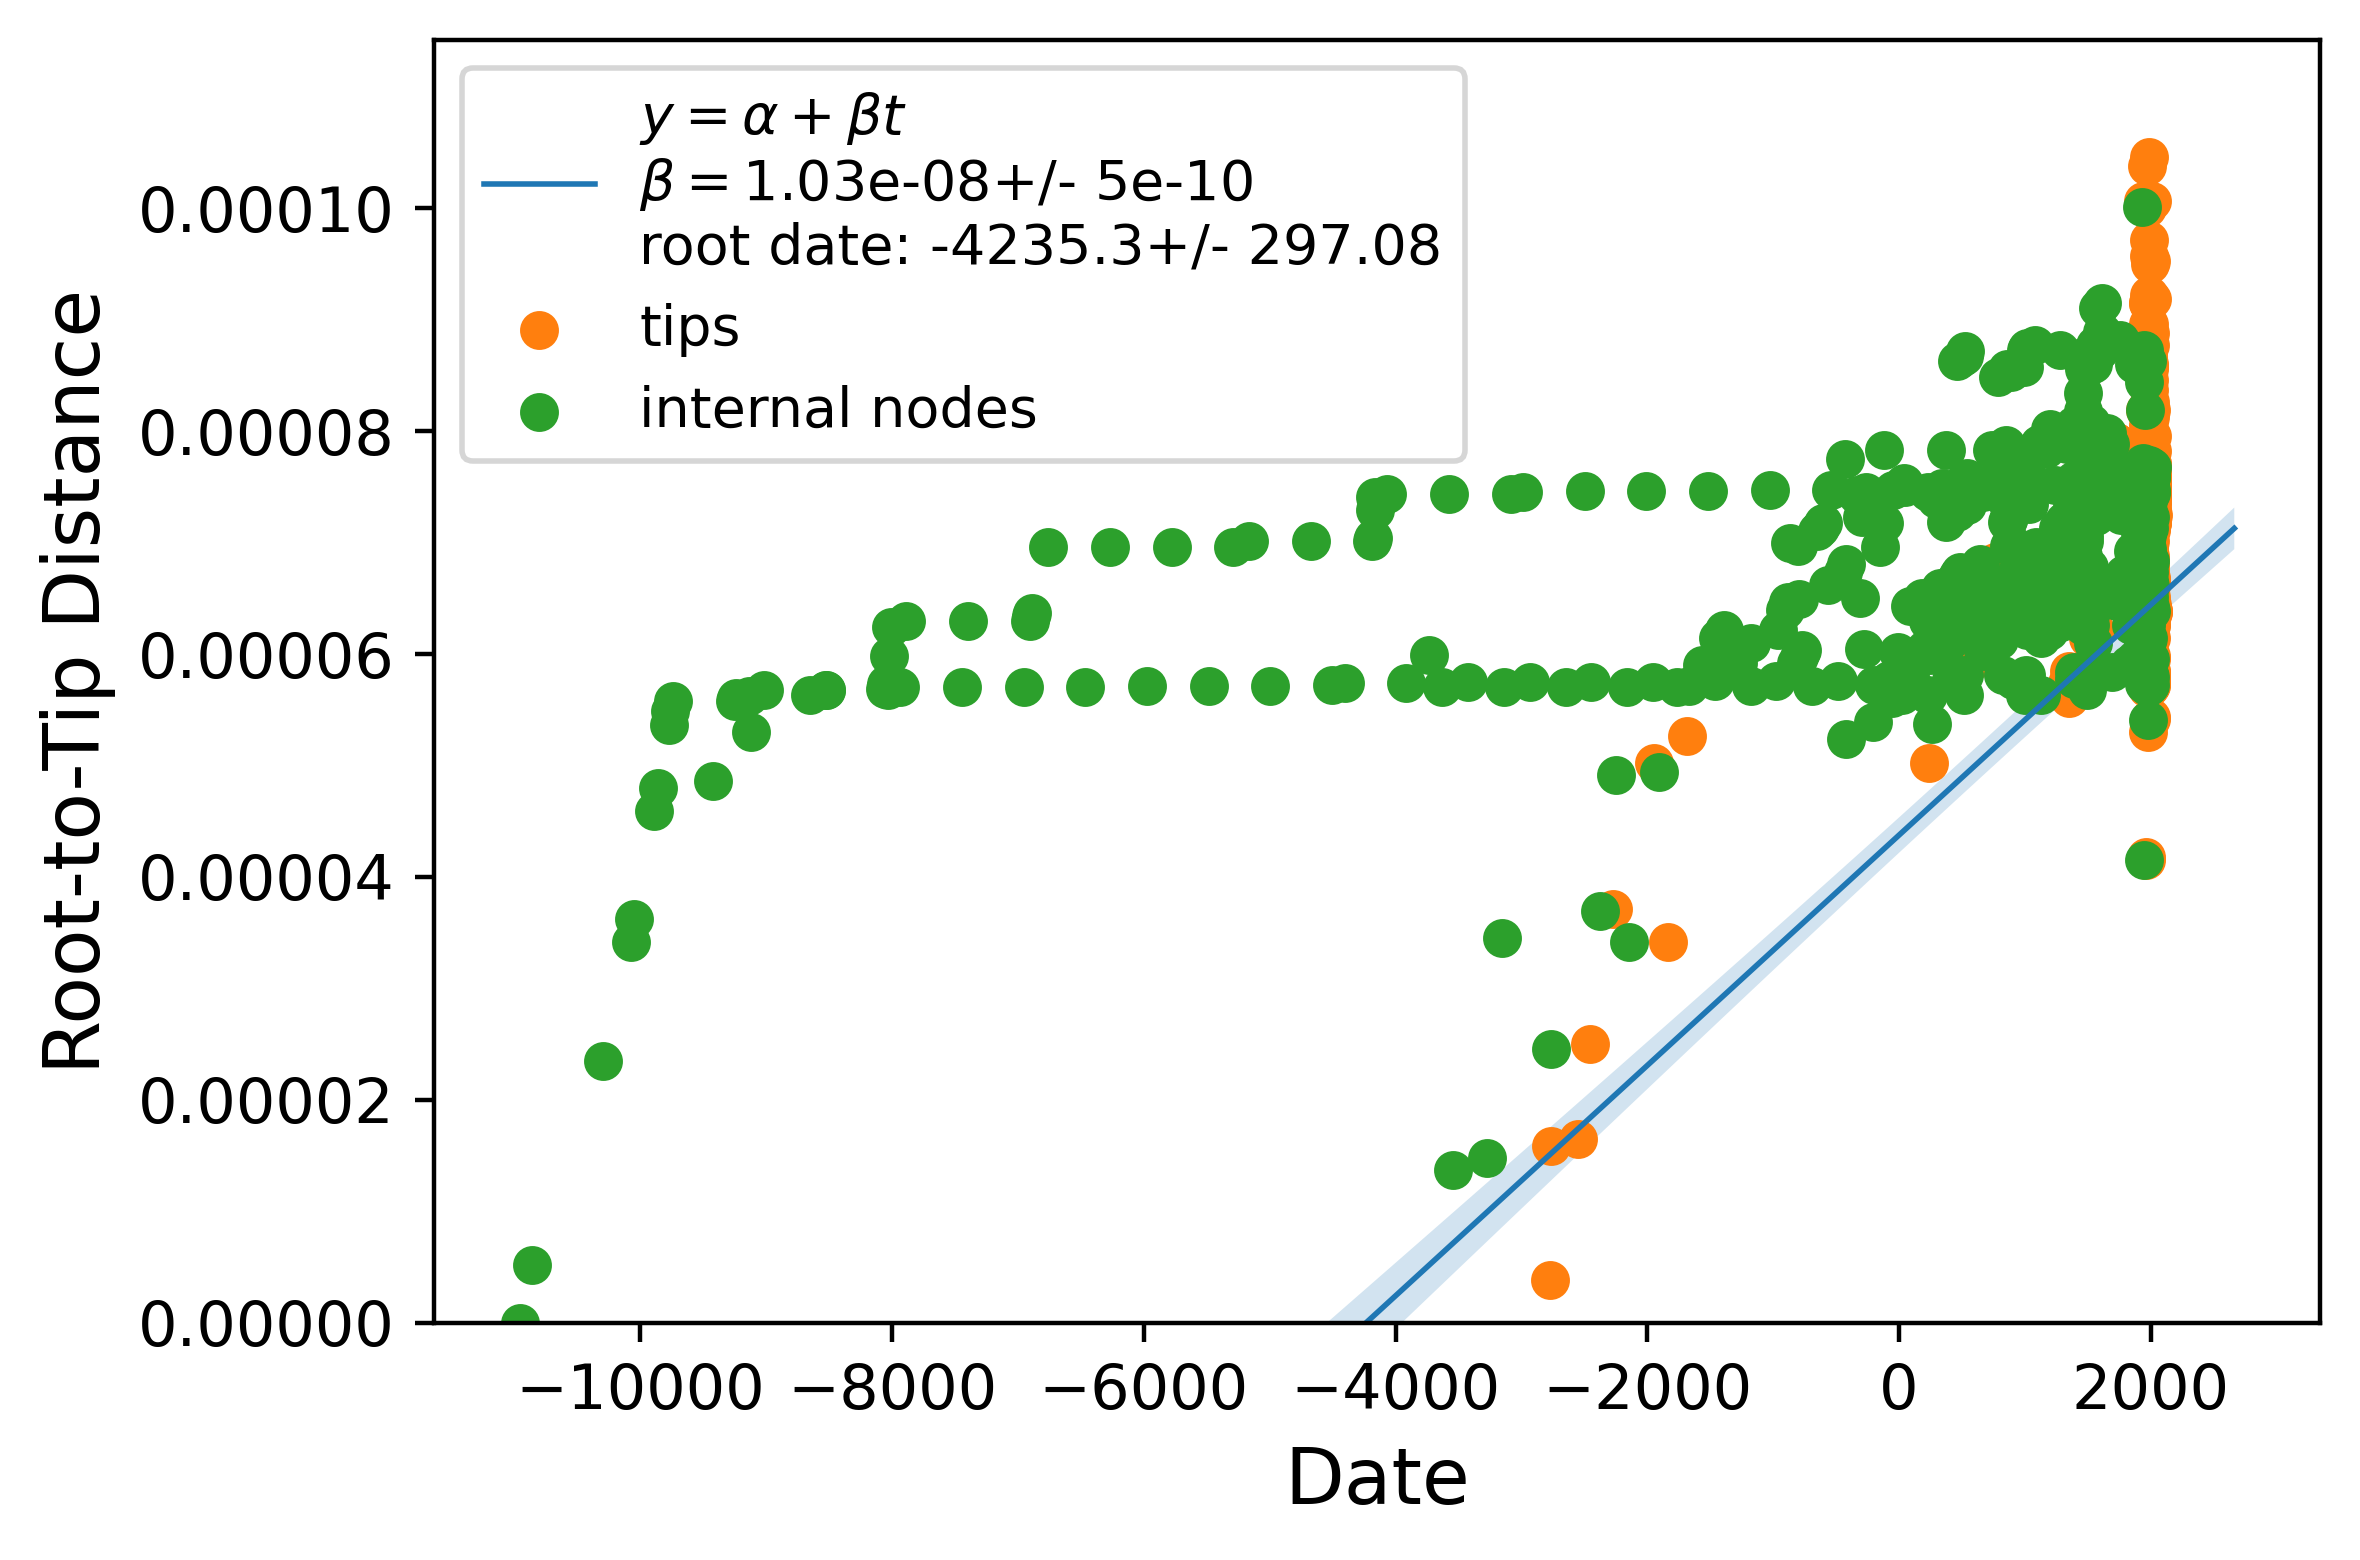

In [71]:
# Root to tip regression
fig, (ax1) = plt.subplots(1, dpi=400)
tt.plot_root_to_tip(
    ax=ax1,
    add_internal=True,
    )
#ax1.get_lines()[0].set_color("#1f77b4")
#ax1.get_lines()[0].set_color("#ff7f0e")
ax1.set_xlabel("Date")
ax1.set_ylabel("Root-to-Tip Distance")
plt.legend(loc=2)

out_path = os.path.join(outdir, "timetree_rtt_post.jpg") 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

In [59]:
tt.tree.common_ancestor("NODE9")

Clade(_orig_gamma=1.0, _v=5.57877e-05, bad_branch=False, date='-9741-03-18', dist2root=5.57877e-05, mutation_length=9.376e-07, name='NODE9', original_length=9.376e-07)

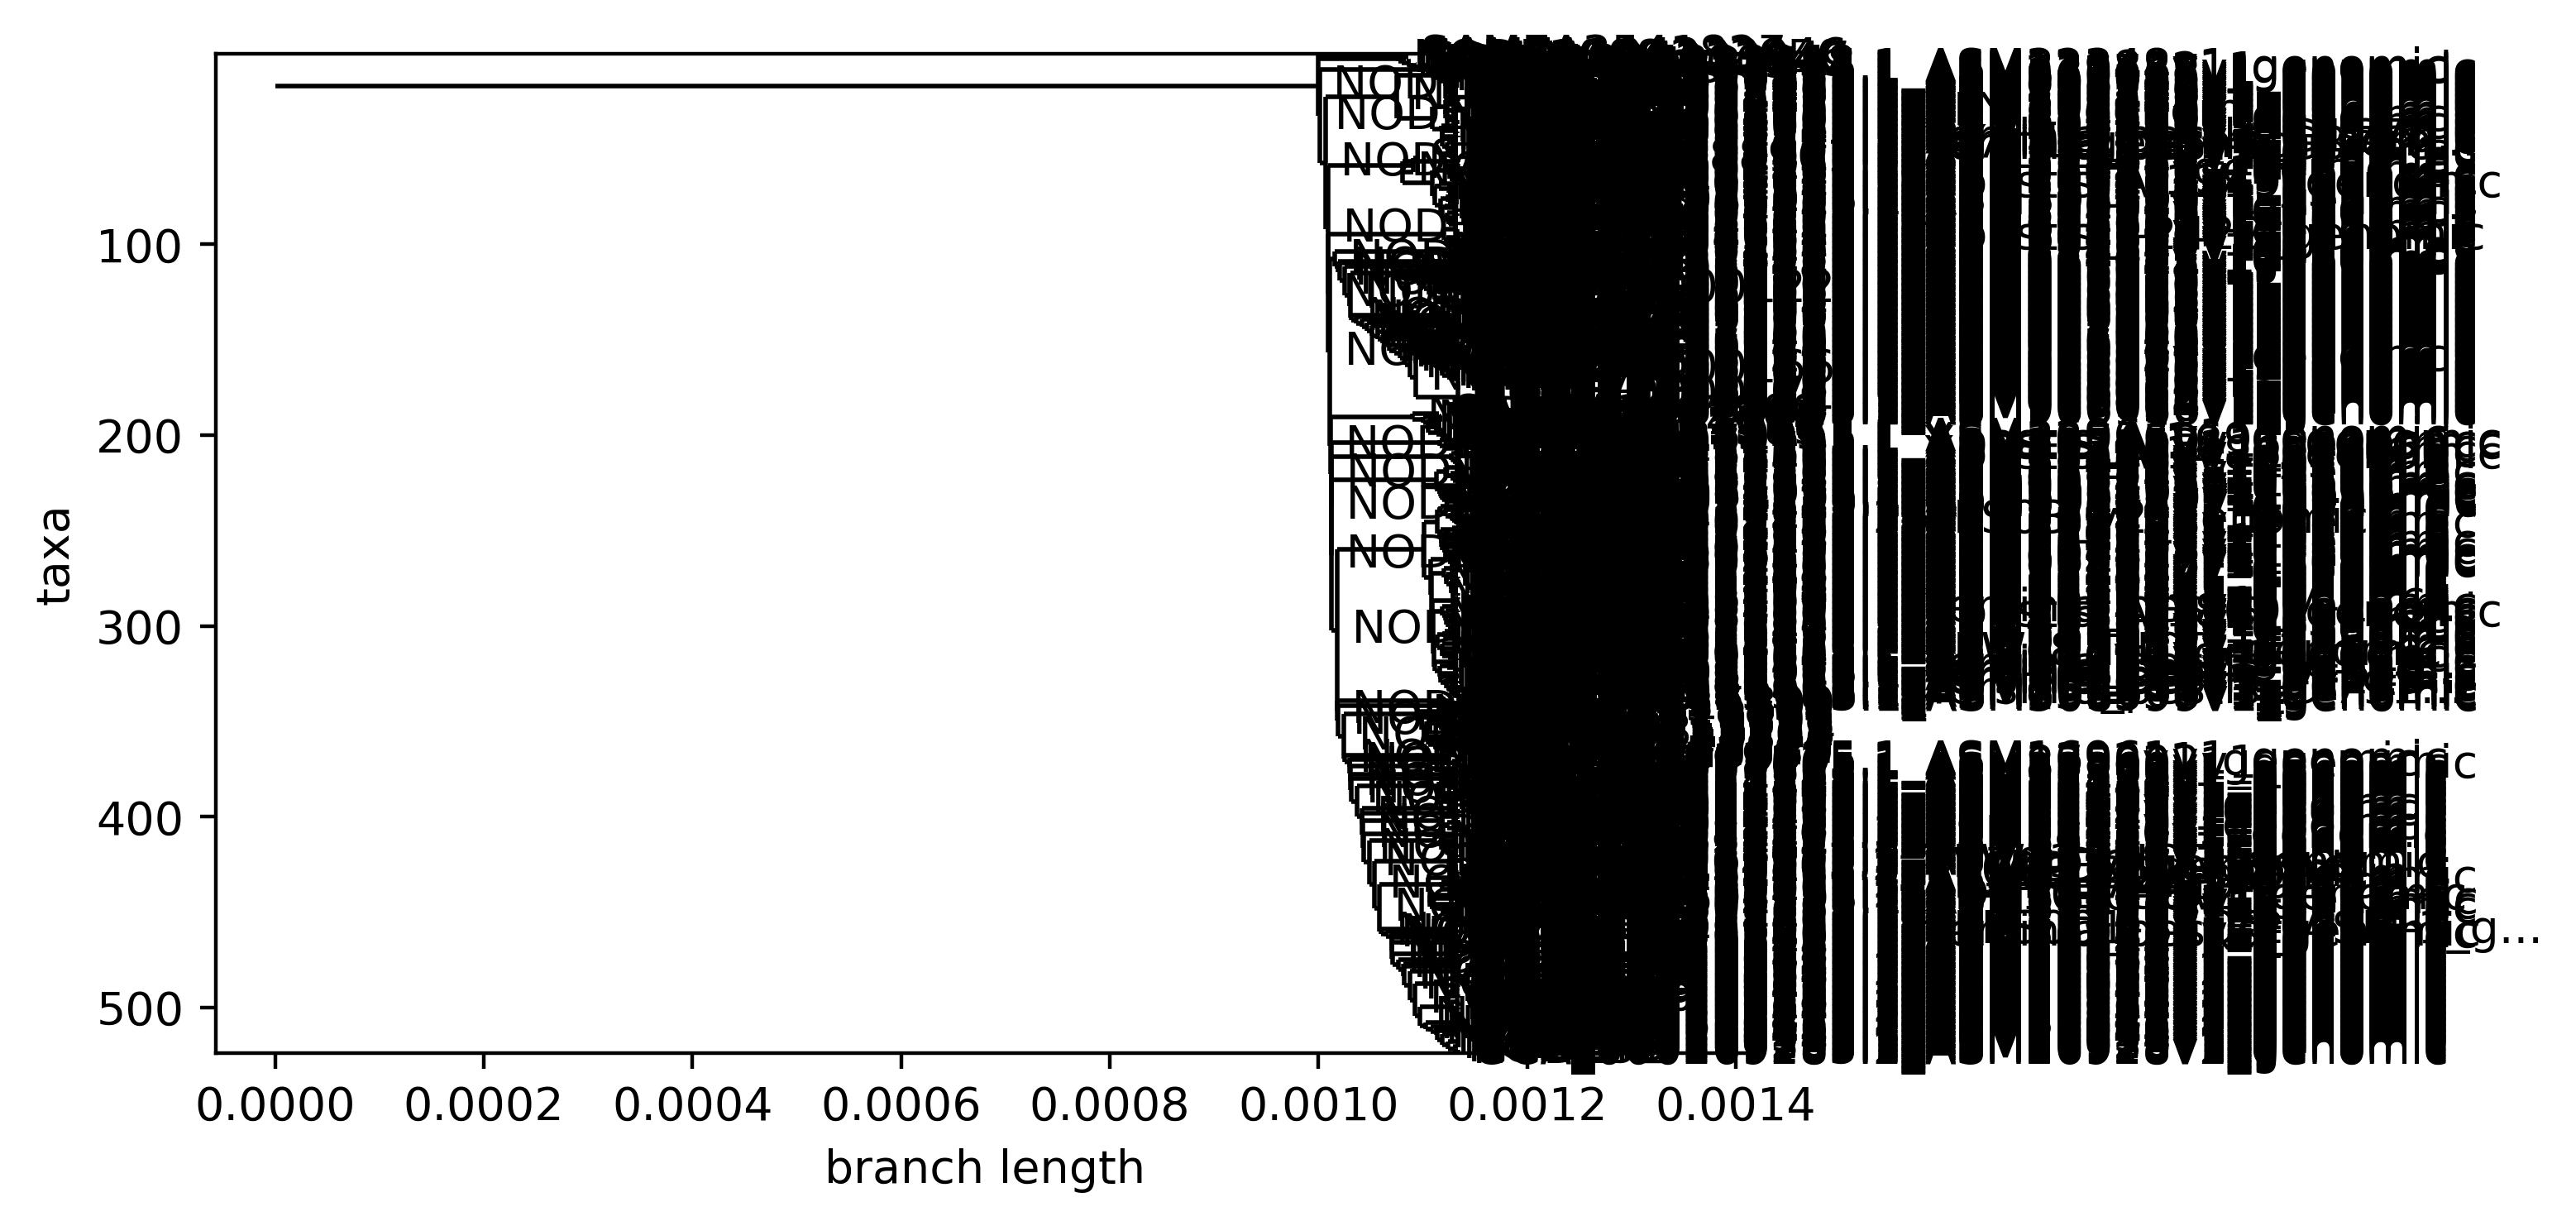

In [48]:
fig, ax1 = plt.subplots(1, dpi=400)

ax1.set_xlim(0.001, 0.0012)

Phylo.draw(
    tt.tree, 
    label_func=lambda x:'', 
    show_confidence=False,
    axes=ax1,
    )

In [ ]:
fig, ax1 = plt.subplots(1)

# Deepest nodes at the top
tt.tree.ladderize(reverse=False)
# Convert branch length to years
tt.branch_length_to_years()

# Draw tree to the canvas
Phylo.draw(tt.tree, 
           axes=ax1, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# Problem #1: The x axis is not in the range root.numdate t maximum tip_date
# Problem #2: The x axis is in weird increments

"""step = 250
axis_pad = 50
date_range = np.max([n.numdate for n in tt.tree.get_terminals()]) #- offset
print(date_range)
ax.set_xlim(-axis_pad,date_range+axis_pad)
ax.set_ylim(500,-50)
ax1.set_xlabel('year')
ax1.set_ylabel('')
ax1.set_yticks([])
"""